In [67]:
import sys, os
import datetime
from datetime import date
sys.path.append(os.environ['minotaur'])

import yaml

%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn

from pylab import rcParams
rcParams['figure.figsize'] = 15,5

from matplotlib.dates import DAILY
from datetime import datetime

from dbs import redshift
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split


In [73]:
# excuse the sloppy sql here. combining many different queries
df = redshift.execute("""

WITH pend AS
(
  SELECT partner_id,
         end_at,
         ROW_NUMBER() OVER (PARTITION BY partner_id ORDER BY end_at DESC) AS rownum
  FROM analytics.partner_subscriptions
  GROUP BY 1,
           2
),
psc AS
(
  SELECT partner_id,
         start_at AS current_subscription_start_at,
         end_at AS current_subscription_end_at,
         plan_name AS current_subscription_plan_name
  FROM (SELECT id,
               partner_id,
               start_at,
               end_at,
               "current",
               plan_name,
               ROW_NUMBER() OVER (PARTITION BY partner_id ORDER BY start_at DESC) AS subscription_number
        FROM analytics.partner_subscriptions) psc
  WHERE psc.subscription_number = 1
  AND   psc."current" = 'true'
),
ends AS
(
  SELECT psc.partner_id,
         psc.current_subscription_start_at,
         psc.current_subscription_plan_name,
         CASE
           WHEN psc.current_subscription_end_at IS NOT NULL THEN CURRENT_DATE
           ELSE pend.end_at
         END AS current_or_end_at
  FROM psc
    LEFT JOIN pend
           ON psc.partner_id = pend.partner_id
          AND pend.rownum = 1
),
churned_sub AS
(
  SELECT partner_id,
         churned_at,
         ROW_NUMBER() OVER (PARTITION BY partner_id ORDER BY churned_at DESC) AS num
  FROM gravity.partner_subscriptions
  WHERE churned_at IS NOT NULL
),
first_sub AS
(
  SELECT partner_id,
         start_at,
         ROW_NUMBER() OVER (PARTITION BY partner_id ORDER BY start_at ASC) AS num
  FROM gravity.partner_subscriptions
)
SELECT partners.id,
       CASE
         WHEN churn.churned_at IS NOT NULL THEN TRUE
         ELSE FALSE
       END AS "churned",
       COALESCE(psd.days_on_platform,0) AS days_on_platform,
       COALESCE(fs.avg_fair_tier,0) AS avg_fair_tier,
       partners.partner_locations_count,
       COALESCE(i.avg_minutes_to_first_gallery_response,0) AS avg_minutes_to_first_gallery_response,
       COALESCE(pa.represented_artists_count,0) AS represented_artists_count,
       COALESCE(pa.partner_artists_no_bio_count,0) AS partner_artists_no_bio_count,
       partners.artists_count,
       partners.artworks_count AS normalize_artworks_count,
       partners.eligible_artworks_count AS normalize_eligible_artworks_count,
       partners.published_for_sale_artworks_count AS normalize_published_for_sale_artworks_count,
       partners.published_not_for_sale_artworks_count AS normalize_published_not_for_sale_artworks_count,
       partners.shows_count AS normalize_shows_count,
       partners.displayable_shows_count AS normalize_displayable_shows_count,
       partners.artists_count AS normalize_artists_count,
       partners.partner_show_documents_count AS normalize_partner_show_documents_count,
       COALESCE(i.inquiry_count,0) AS normalize_inquiry_count,
       COALESCE(i.inquiry_purchase_count,0) AS normalize_inquiry_purchase_count,
       COALESCE(i.total_inquiry_purchase_value,0) AS normalize_total_inquiry_purchase_value,
       COALESCE(p.purchase_count,0) AS normalize_purchase_count,
       COALESCE(p.total_purchase_value,0) AS normalize_total_purchase_value,
       COALESCE(v.cms_session_count,0) AS normalize_cms_session_count,
       COALESCE(a.artwork_without_medium_count,0) AS normalize_artwork_without_medium_count,
       COALESCE(a.complete_artwork_count,0) AS normalize_complete_artwork_count,
       COALESCE(a.complete_published_artwork_count,0) AS normalize_complete_published_artwork_count,
       COALESCE(a.complete_published_not_for_sale_artwork_count,0) AS normalize_complete_published_not_for_sale_artwork_count,
       COALESCE(a.artwork_without_category_count,0) AS normalize_artwork_without_category_count,
       COALESCE(a.price_visible_artwork_count,0) AS normalize_price_visible_artwork_count,
       COALESCE(a.priced_artwork_count,0) AS normalize_priced_artwork_count,
       COALESCE(posmen.partner_positron_mentions,0) AS normalize_partner_positron_mentions,
       COALESCE(fs.fair_count,0) AS normalize_fair_count,
       COALESCE(fs.show_artwork_count,0) AS normalize_show_artwork_count,
       COALESCE(im.avg_minutes_to_first_gallery_response_last_90_days,0) AS avg_minutes_to_first_gallery_response_last_90_days,
       COALESCE(i.inquiries_last_30_days_count,0) AS inquiries_last_30_days_count,
       COALESCE(p.purchase_in_last_180_days_count,0) AS purchase_in_last_180_days_count,
       COALESCE(im.inquiry_response_rate_last_90_days,0) AS inquiry_response_rate_last_90_days,
       COALESCE(v.cms_session_count_last_30_days,0) AS cms_session_count_last_30_days,
       COALESCE(v.cms_session_count_last_14_days,0) AS cms_session_count_last_14_days,
       COALESCE(v.cms_session_count_last_7_days,0) AS cms_session_count_last_7_days,
       COALESCE(a.published_artwork_count_last_30_days,0) AS published_artwork_count_last_30_days,
       COALESCE(a.avg_price_listed_usd,0) AS avg_price_listed_usd,
       COALESCE(adi.artwork_impression_count_last_6_months,0) AS artwork_impression_count_last_6_months,
       COALESCE(adi.artwork_impression_count_last_30_days,0) AS artwork_impression_count_last_30_days,
       COALESCE(adp.artwork_pageviews_count_last_6_months,0) AS artwork_pageviews_count_last_6_months,
       COALESCE(adp.artwork_pageviews_count_last_30_days,0) AS artwork_pageviews_count_last_30_days,
       COALESCE(pa.avg_represented_artist_follow_count,0) AS avg_represented_artist_follow_count,
       COALESCE(l.lockout_last_120_days_count,0) AS lockout_last_120_days_count,
       COALESCE(pos.writer_upload_last_30_days_count,0) AS writer_upload_last_30_days_count
FROM gravity.partners
  LEFT JOIN (SELECT partner_id,
                    SUM(datediff ('day',start_at,CASE WHEN end_at > CURRENT_DATE THEN CURRENT_DATE ELSE end_at END)) AS days_on_platform
             FROM analytics.partner_subscriptions
             GROUP BY 1) psd ON psd.partner_id = partners.id
  LEFT JOIN ends ON ends.partner_id = partners.id
  LEFT JOIN (SELECT i.partner_id,
                    AVG(i.minutes_to_first_gallery_response) AS avg_minutes_to_first_gallery_response,
                    COUNT(i.inquiry_id) AS inquiry_count,
                    COUNT(CASE WHEN datediff (DAY,i.created_at,ends.current_or_end_at) BETWEEN 0 AND 30 THEN i.inquiry_id END) AS inquiries_last_30_days_count,
                    SUM(i.number_of_purchases) AS inquiry_purchase_count,
                    SUM(i.total_purchase_price) AS total_inquiry_purchase_value
             FROM analytics.inquiry_requests i
               LEFT JOIN ends ON i.partner_id = ends.partner_id
             GROUP BY 1) i ON i.partner_id = partners.id
  LEFT JOIN (SELECT p.partner_id,
                    COUNT(p.id) AS purchase_count,
                    COUNT(CASE WHEN datediff ('days',p.sale_date::DATE,ends.current_or_end_at) BETWEEN 0 AND 180 THEN p.id END) AS purchase_in_last_180_days_count,
                    SUM(p.sale_price) AS total_purchase_value
             FROM analytics.purchases p
               LEFT JOIN ends ON p.partner_id = ends.partner_id
             GROUP BY 1) p ON p.partner_id = partners.id
  LEFT JOIN (SELECT to_id AS partner_id,
                    100.0 *COUNT(replied_at)::FLOAT/ NULLIF(COUNT(*),0) AS inquiry_response_rate_last_90_days,
                    AVG(datediff ('minute',created_at,replied_at)) AS avg_minutes_to_first_gallery_response_last_90_days
             FROM impulse.conversations c
               LEFT JOIN ends ON c.to_id = ends.partner_id
             WHERE to_type = 'Partner'
             AND   dismissed_at IS NULL
             AND   (datediff('days',created_at,ends.current_or_end_at) BETWEEN 0 AND 90 OR datediff('days',replied_at,ends.current_or_end_at) BETWEEN 0 AND 90)
             GROUP BY 1) im ON im.partner_id = partners.id
  LEFT JOIN (SELECT v.partner_id,
                    COUNT(v.session_id) AS cms_session_count,
                    COUNT(CASE WHEN datediff ('day',v.session_start_at,ends.current_or_end_at) <= 30 THEN v.session_id END) AS cms_session_count_last_30_days,
                    COUNT(CASE WHEN datediff ('day',v.session_start_at,ends.current_or_end_at) <= 14 THEN v.session_id END) AS cms_session_count_last_14_days,
                    COUNT(CASE WHEN datediff ('day',v.session_start_at,ends.current_or_end_at) <= 7 THEN v.session_id END) AS cms_session_count_last_7_days
             FROM analytics.volt_session_facts_2 v
               LEFT JOIN ends ON v.partner_id = ends.partner_id
             GROUP BY 1) v ON v.partner_id = partners.id
-- this join factors in deleted artworks, while the core gravity metrics do not.

  LEFT JOIN (SELECT a.partner_id,
                    COUNT(a.id) AS complete_artwork_count,
                    COUNT(CASE WHEN a.published = TRUE THEN a.id END) AS complete_published_artwork_count,
                    COUNT(CASE WHEN a.published = TRUE AND a.availability = 'not for sale' THEN a.id END) AS complete_published_not_for_sale_artwork_count,
                    COUNT(CASE WHEN a.published = TRUE AND datediff ('days',published_at,ends.current_or_end_at) BETWEEN 0 AND 30 THEN a.id END) AS published_artwork_count_last_30_days,
                    COUNT(CASE WHEN a.medium IS NULL THEN a.id END) AS artwork_without_medium_count,
                    COUNT(CASE WHEN a.category IS NULL THEN a.id END) AS artwork_without_category_count,
                    COUNT(CASE WHEN COALESCE(a.price_listed,a.price_min,a.price_max) IS NOT NULL AND (NOT a.price_hidden OR a.display_price_range) THEN a.id END) AS price_visible_artwork_count,
                    COUNT(CASE WHEN COALESCE(a.price_listed,a.price_min,a.price_max) IS NOT NULL THEN a.id END) AS priced_artwork_count,
                    AVG(CASE WHEN a.published_at IS NOT NULL THEN a.price_listed_usd END) AS avg_price_listed_usd
             FROM analytics.artworks a
               LEFT JOIN ends ON a.partner_id = ends.partner_id
             GROUP BY 1) a ON a.partner_id = partners.id
  LEFT JOIN (SELECT a.partner_id,
                    SUM(CASE WHEN datediff ('day',adi."date",ends.current_or_end_at) BETWEEN 0 AND 180 THEN adi."count" END) AS artwork_impression_count_last_6_months,
                    SUM(CASE WHEN datediff ('day',adi."date",ends.current_or_end_at) BETWEEN 0 AND 30 THEN adi."count" END) AS artwork_impression_count_last_30_days
             FROM analytics.artworks a
               LEFT JOIN analytics.artwork_daily_impressions adi ON adi.artwork_id = a.id
               LEFT JOIN ends ON a.partner_id = ends.partner_id
             GROUP BY 1) adi ON adi.partner_id = partners.id
  LEFT JOIN (SELECT a.partner_id,
                    SUM(CASE WHEN datediff ('day',adp."date",ends.current_or_end_at) BETWEEN 0 AND 180 THEN adp."artwork_pageviews" END) AS artwork_pageviews_count_last_6_months,
                    SUM(CASE WHEN datediff ('day',adp."date",ends.current_or_end_at) BETWEEN 0 AND 30 THEN adp."artwork_pageviews" END) AS artwork_pageviews_count_last_30_days
             FROM analytics.artworks a
               LEFT JOIN analytics.artworks_daily_pageviews adp ON adp.artwork_id = a.id
               LEFT JOIN ends ON a.partner_id = ends.partner_id
             GROUP BY 1) adp ON adp.partner_id = partners.id
  LEFT JOIN (SELECT pa.partner_id,
                    COUNT(DISTINCT CASE WHEN pa.has_biography = 'false' AND a.has_blurb = 'false' THEN pa.artist_id END) AS partner_artists_no_bio_count,
                    AVG(CASE WHEN pa.represented_by = 'true' THEN a.follow_count END) AS avg_represented_artist_follow_count,
                    COUNT(DISTINCT CASE WHEN pa.represented_by = 'true' THEN pa.artist_id END) AS represented_artists_count
             FROM gravity.partner_artists pa
               LEFT JOIN gravity.artists a ON a.id = pa.artist_id
             GROUP BY 1) pa ON pa.partner_id = partners.id
  LEFT JOIN (SELECT s.partner_id,
                    1.00 *AVG(f.tier) AS avg_fair_tier,
                    COUNT(f.id) AS fair_count,
                    SUM(s.artworks_count) AS show_artwork_count
             FROM gravity.partner_shows s
               LEFT JOIN gravity.fairs f ON f.id = s.fair_id
             GROUP BY 1) fs ON fs.partner_id = partners.id
  LEFT JOIN (SELECT root_key,
                    COUNT(root_key) AS lockout_last_120_days_count
             FROM gravity.changes gc
               LEFT JOIN ends ON gc.root_key = ends.partner_id
             WHERE JSON_EXTRACT_PATH_TEXT(modified,'partner_flags','subscription_payment_past_due') = 'true'
             AND   datediff('days',"TIME",ends.current_or_end_at) BETWEEN 0 AND 120
             GROUP BY 1) l ON l.root_key = partners.id
  LEFT JOIN (SELECT partner_channel_id,
                    COUNT(*) AS writer_upload_last_30_days_count
             FROM positron_articles pos
               LEFT JOIN ends ON pos.partner_channel_id = ends.partner_id
             WHERE datediff('days',pos.published_at,ends.current_or_end_at) BETWEEN 0 AND 30
             GROUP BY 1) pos ON pos.partner_channel_id = partners.id
  LEFT JOIN (SELECT id,
                    COUNT AS partner_positron_mentions
             FROM analytics.partner_positron_mentions) posmen ON posmen.id = partners.id
  LEFT JOIN churned_sub churn
         ON partners.id = churn.partner_id
        AND churn.num = 1
  INNER JOIN first_sub f
          ON partners.id = f.partner_id
         AND f.num = 1
         AND f.start_at < '8/1/2016'
WHERE contract_type = 'Subscription'


""")


In [74]:
df = df.set_index(['id'],drop=True)
df = df.fillna(0)
df.head()

,churned,days_on_platform,avg_fair_tier,partner_locations_count,avg_minutes_to_first_gallery_response,represented_artists_count,partner_artists_no_bio_count,artists_count,normalize_artworks_count,normalize_eligible_artworks_count,...,cms_session_count_last_7_days,published_artwork_count_last_30_days,avg_price_listed_usd,artwork_impression_count_last_6_months,artwork_impression_count_last_30_days,artwork_pageviews_count_last_6_months,artwork_pageviews_count_last_30_days,avg_represented_artist_follow_count,lockout_last_120_days_count,writer_upload_last_30_days_count
id,,,,,,,,,,,,,,,,,,,,,
4d8b92c34eb68a1b2c0004a3,False,1264,3.00,4,1648,29,52,111,1432,1125,...,3,21,4293.630259,155446,30179,7853,1204,106,0,0
4d8b92c54eb68a1b2c0004f3,True,115,3.00,1,252,24,13,38,458,44,...,0,0,8592.385787,0,0,0,0,149,0,0
4ddd6bb279456d0001000535,False,1330,2.00,2,15662,0,0,38,165,81,...,0,0,148375.000000,0,0,0,0,0,0,0
4ddfa7ca9bcd63000100f26a,True,911,2.00,4,1557,61,3,71,448,316,...,2,0,91117.738667,75791,7915,12490,1403,2705,0,0
4dd68f8e110b7700010045e2,False,1052,2.00,7,3100,57,13,69,538,249,...,5,0,81017.722293,182042,13649,16575,1869,2617,0,0


In [75]:

#normalizing for time on platform made the regression worse
dfnorm = df.copy()
normalize_columns = [c for c in dfnorm.columns if c.startswith('normalize')]

dfnorm[normalize_columns] = dfnorm[normalize_columns].apply(lambda x: x / (dfnorm.days_on_platform / 30))


In [77]:
X = df.copy()
y = df['churned']
del X['churned']
del X['days_on_platform']


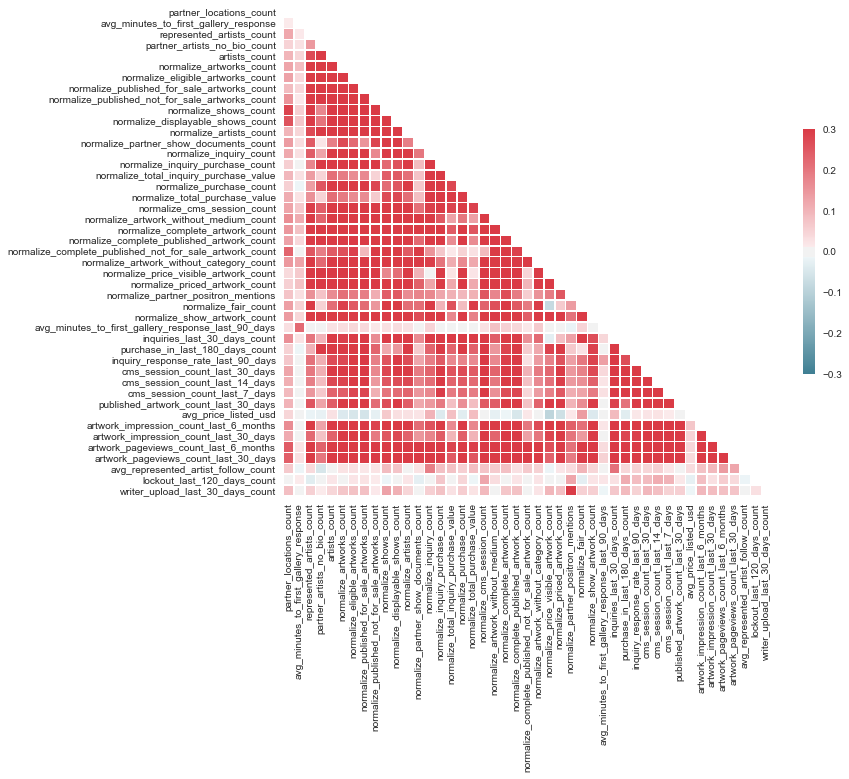

In [78]:
sns.set(style="white")

corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [86]:
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
sgd = SGDRegressor(n_iter=100000, eta0=.001)
sgd = sgd.fit(X_train,y_train)
y_predtrain = sgd.predict(X_test)

In [88]:
#random model is .5 need to go to -> sqrt of mse 
mse = sklearn.metrics.mean_squared_error(y_test, y_predtrain)

print('sqrt of mean squared error:\n{}'.
      format(np.sqrt(mse)))
print('standard deviation between predicted and test:\n{}'
     .format(np.std(y_predtrain - y_test)))
print('coeficient:\n{}'
     .format(sgd.coef_))
print('intercept:\n{}'
     .format(sgd.intercept_))
print('regression score:\n{}'
     .format(sgd.score(X_test,y_test)))

sqrt of mean squared error:
0.27914353234860223
mean squared error:
0.07792111165205513
standard deviation between predicted and test:
0.2790978565132745
coeficient:
[-0.03896663 -0.09154093 -0.25213265  0.07104104  0.00283523  0.00274799
  0.41210174 -0.17696555 -0.28081384  0.15136115 -0.03555282 -0.40810069
  0.00274799  0.06766709 -0.10572067 -0.01865509  0.00094262 -0.01357354
 -0.03970669 -0.27135393 -0.06118176  0.15879768 -0.17624377  0.08743492
 -0.2329493   0.01899211 -0.07642886  0.087199   -0.00958451  0.04303712
 -0.03960657 -0.02497262  0.13019501 -0.2465105   0.10370156 -0.00823043
 -0.00153422  0.10832558 -0.03073873  0.12718334 -0.00202748  0.05503874
  0.00446985  0.07559194 -0.00469116 -0.01471851]
intercept:
[ 0.30395306]
regression score:
0.13836950891092403


In [89]:
col = pd.DataFrame(sgd.coef_,X_train.columns)
col.sort_values(0,ascending=False)

,0
normalize_artworks_count,0.412102
normalize_complete_artwork_count,0.158798
normalize_published_not_for_sale_artworks_count,0.151361
purchase_in_last_180_days_count,0.130195
artwork_impression_count_last_6_months,0.127183
published_artwork_count_last_30_days,0.108326
cms_session_count_last_30_days,0.103702
normalize_complete_published_not_for_sale_artwork_count,0.087435
normalize_partner_positron_mentions,0.087199
avg_represented_artist_follow_count,0.075592


In [ ]:
#correlation matrix
#gives visual overview if some features correlated with each other

### Poly Feature / Ridge Regression

In [90]:
poly = PolynomialFeatures(degree=2)
X = df.copy()
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [93]:
ridge = Ridge(alpha=20,fit_intercept=False).fit(X_train, y_train)
y_predtrain = ridge.predict(X_test)

/Users/nicholassewitz/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.1677247322884797e-23
  ' condition number: {}'.format(rcond), RuntimeWarning)


In [92]:
# This looks to be like the best model when it comes to prediction
mse = sklearn.metrics.mean_squared_error(y_test, y_predtrain)
print('mean squared error:\n{}'
     .format(mse))
print('standard deviation between predicted and test:\n{}'
     .format(np.std(y_predtrain - y_test)))
print('intercept:\n{}'
     .format(ridge.intercept_))
print('regression score:\n{}'
     .format(ridge.score(X_test,y_test)))

mean squared error:
39299883494.84358
standard deviation between predicted and test:
197637.24803348884
intercept:
0.0
regression score:
-481424461546.3267
